In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'SVM(C=1.0)特徴量ミニマム'
notebook_name = '044'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

044_submission.csv 044


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', StandardScaler(), discrete_features),
            ('categorical', 'passthrough', categorical_features)
        ]
    )
    clf = SVC(random_state=SEED, C=1.0, class_weight='balanced')
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
for c in categorical_features:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

categorical_features_1hot = []
for c in categorical_features:
    categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
print(categorical_features_1hot)

features = discrete_features + categorical_features_1hot

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['inningNo', 'B', 'totalPitchingCount', 'numRunners', 'S', 'O']
['b1_1', 'b2_1', 'b3_1', 'batterID_0', 'batterID_2', 'batterID_5', 'batterID_9', 'batterID_11', 'batterID_12', 'batterID_15', 'batterID_18', 'batterID_19', 'batterID_21', 'batterID_22', 'batterID_26', 'batterID_27', 'batterID_28', 'batterID_29', 'batterID_31', 'batterID_34', 'batterID_36', 'batterID_37', 'batterID_39', 'batterID_42', 'batterID_45', 'batterID_47', 'batterID_50', 'batterID_55', 'batterID_56', 'batterID_58', 'batterID_60', 'batterID_67', 'batterID_70', 'batterID_72', 'batterID_73', 'batterID_75', 'batterID_80', 'batterID_82', 'batterID_84', 'batterID_85', 'batterID_87', 'batterID_89', 'batterID_91', 'batterID_98', 'batterID_102', 'batterID_103', 'batterID_105', 'batterID_106', 'batterID_111', 'batterID_112', 'batterID_114', 'batterID_117', 'batterID_118', 'b

In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features_1hot)
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[1393 1713  661  661  425  130    3   80]
 [ 467 2025  423  441  278   72    3   37]
 [ 301  523  884  372  238   48    0   27]
 [ 169  359  169  847  137   19    1    8]
 [  20   32   10    6  468    4    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[267 459 171 191 134  23   1  21]
 [142 434 116 125  83  21   1  14]
 [ 84 138 134 144  76  14   0   9]
 [ 53  97  98 108  56  11   0   4]
 [ 18  31  32  31  20   2   0   1]
 [  7   9   2   8   8   3   0   0]
 [  2   0   0   1   0   0   0   0]
 [  1   8   7   4   4   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[1414 1723  614  651  480  105    4   75]
 [ 496 1969  375  475  307   79    4   41]
 [ 318  534  865  370  229   48    1   28]
 [ 181  384  161  832  131   14    0    6]
 [  16   28   1

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.484243,0.155416
std,0.008312,0.004693
min,0.473658,0.149398
25%,0.481802,0.151656
50%,0.482625,0.156834
75%,0.486642,0.158968
max,0.496491,0.160225


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,2,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,4,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,3.125085,4.235129,6.276822,5.262578,7.256631,0.720004,-0.279802,1.727561,27446,1
1,5.264908,4.171144,7.284334,6.272880,3.070425,0.712094,-0.265641,1.720006,113,1
2,6.287627,7.292461,5.272696,4.124247,2.734722,0.715595,-0.256465,1.718006,4479,1
3,6.283192,7.292983,4.259712,5.268569,2.786637,0.708997,-0.291148,1.721958,29080,1
4,7.283493,4.192846,6.264587,5.246873,3.154621,0.709302,-0.260000,1.729961,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,6.273349,7.288894,5.224959,4.237584,3.149714,1.749307,-0.295134,0.716638,24272,5
33804,4.192492,2.986129,6.287251,7.286848,5.206262,1.849421,-0.298166,0.713960,29106,5
33805,4.027651,2.809902,6.286787,7.295977,5.238357,0.760746,-0.306783,1.814217,20679,5
33806,7.291708,2.790766,4.258770,5.277513,6.274252,1.731256,-0.292370,0.707780,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,24.161967,36.411574,26.228031,26.188005,17.569690,8.753459,-1.475849,3.741663
1,1,31.395642,36.478434,25.150651,21.965301,11.898952,11.505746,-1.479569,3.570849
2,2,20.335230,14.655507,35.411175,29.365297,29.290687,4.675259,-1.454325,7.797098
3,3,31.426445,36.467631,17.036696,23.478405,18.821360,10.151393,-1.500059,3.776468
4,4,31.425848,36.457141,21.999575,21.951125,18.783766,7.635629,-1.485390,4.656543
...,...,...,...,...,...,...,...,...,...
33803,33803,36.466338,17.082388,27.315127,29.307758,21.136771,8.784166,-1.477622,3.517017
33804,33804,31.396562,36.463054,16.791539,26.224859,20.094081,4.638315,-1.520725,7.741417
33805,33805,27.368494,33.407227,20.701286,33.399830,14.383170,3.621896,-1.500917,8.948676
33806,33806,19.016173,25.199789,31.289780,36.332386,18.686067,5.738070,-1.429725,6.710629


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,1
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.195900
1    0.447616
2    0.103053
3    0.180786
4    0.070368
5    0.001952
7    0.000325
Name: y, dtype: float64

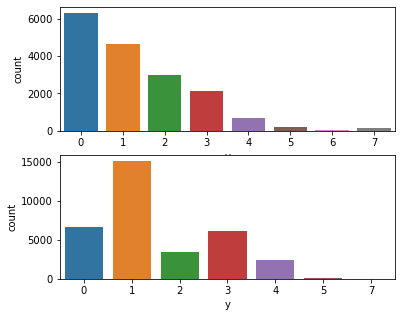

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.4842434846289324, 0.1554161833346223)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"044_submission.csv","Stratified-Kfold(K=5)","0.484243","0.155416","","SVM(C=1.0)特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.21 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [21]:
imp_df

""


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
